# Ch9 機械学習による時系列解析

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1.5)
c_list = sns.color_palette().as_hex()
color_num = len(c_list)

## 9.1 時系列の分類

In [2]:
# !pip install cesium

### サンプルデータ

この章では、時系列解析パッケージである[cesium](https://cesium-ml.org/)を利用する。

cesiumにはサンプルデータが多数含まれており、今回は5つのカテゴリのEEGデータを扱う。

http://cesium-ml.org/docs/auto_examples/plot_EEG_Example.html


In [3]:
from cesium import datasets

In [4]:
eeg = datasets.fetch_andrzejak()

display(type(eeg))

Loaded data from cached archive.


dict

In [5]:
for k, v in eeg.items():
    t = str(type(v))
    print(f"{k: >13}, value_type:{t: <25}, value_len:{len(v): >4}")

        times, value_type:<class 'list'>           , value_len: 500
 measurements, value_type:<class 'list'>           , value_len: 500
      classes, value_type:<class 'numpy.ndarray'>  , value_len: 500
      archive, value_type:<class 'str'>            , value_len:  55
       header, value_type:<class 'str'>            , value_len:  52


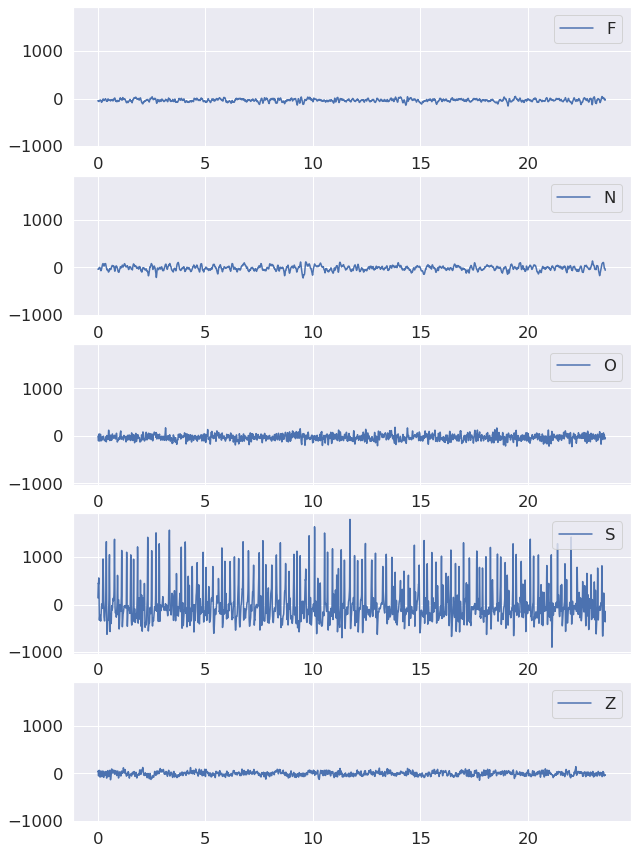

In [6]:
nc = len(np.unique(eeg["classes"]))
fig = plt.figure(figsize=(10, 3*nc))
ax = fig.subplots(nc, 1, sharey=True)
for i, c in enumerate(np.unique(eeg["classes"])):
    idx = np.where(eeg["classes"]==c)[0][0]
    ax[i].plot(eeg["times"][idx], eeg["measurements"][idx], label=f"{c}");
    ax[i].legend();

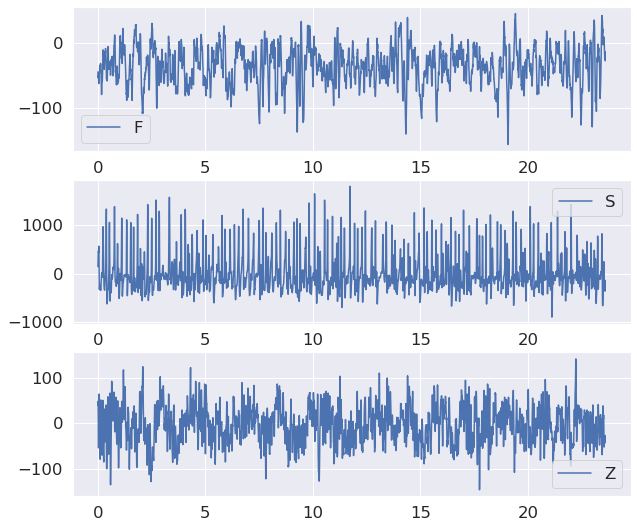

In [7]:
tgt_class = ["F", "S", "Z"]
nc = len(tgt_class)
fig = plt.figure(figsize=(10, 3*nc))
ax = fig.subplots(nc, 1)
for i, c in enumerate(tgt_class):
    idx = np.where(eeg["classes"]==c)[0][0]
    ax[i].plot(eeg["times"][idx], eeg["measurements"][idx], label=f"{c}");
    ax[i].legend();

クラスによって振幅の幅が異なる。また、Sは特に正の方に偏っていることも見える。

CPU times: user 28.8 s, sys: 10.1 ms, total: 28.9 s
Wall time: 28.8 s


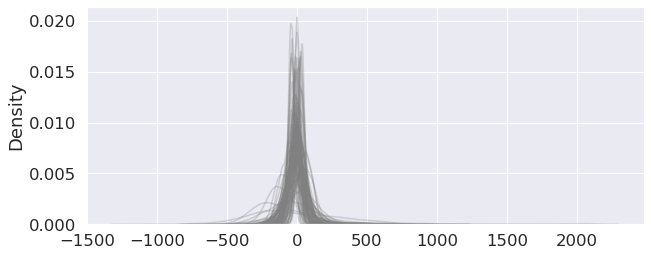

In [8]:
%%time
tgt_class = "F"
fig = plt.figure(figsize=(10, 4))
ax = fig.subplots(1, 1)
tgt_idxs = np.where(eeg["classes"]==tgt_class)[0]
for i, idx in enumerate(tgt_idxs):
    sns.kdeplot(eeg["measurements"][idx], color=(0.5, 0.5, 0.5, 0.3), ax=ax);

CPU times: user 29.5 s, sys: 69.4 ms, total: 29.6 s
Wall time: 29.6 s


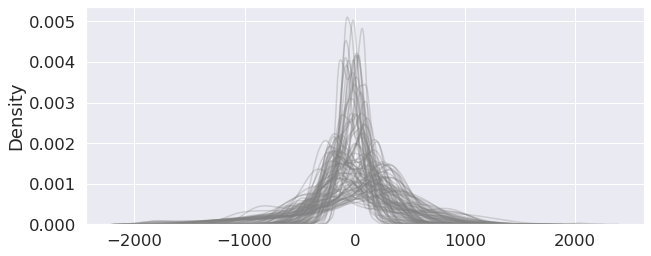

In [9]:
%%time
tgt_class = "S"
fig = plt.figure(figsize=(10, 4))
ax = fig.subplots(1, 1)
tgt_idxs = np.where(eeg["classes"]==tgt_class)[0]
for i, idx in enumerate(tgt_idxs):
    sns.kdeplot(eeg["measurements"][idx], color=(0.5, 0.5, 0.5, 0.3), ax=ax);

CPU times: user 29.3 s, sys: 118 ms, total: 29.4 s
Wall time: 29.4 s


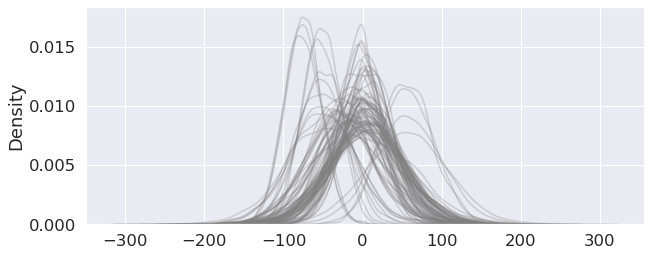

In [10]:
%%time
tgt_class = "Z"
fig = plt.figure(figsize=(10, 4))
ax = fig.subplots(1, 1)
tgt_idxs = np.where(eeg["classes"]==tgt_class)[0]
for i, idx in enumerate(tgt_idxs):
    sns.kdeplot(eeg["measurements"][idx], color=(0.5, 0.5, 0.5, 0.3), ax=ax);

各クラスの標本を1次元ヒストグラム（KDE）で確認。クラス内のばらつきはそこそこありそう。
特に、Fは外れ値的な値が出ているようだ。


### 特徴量の生成と特徴量選択

cesiumパッケージを使って実装済みの特徴量を計算する。

利用できる特徴量の一覧は以下参照

http://cesium-ml.org/docs/feature_table.html

In [11]:
from cesium import featurize as ft

In [12]:
features_to_use = [
    "amplitude",
    "percent_beyond_1_std",
    "percent_close_to_median",
    "skew",
    "max_slope", 
]
fset_cesium = ft.featurize_time_series(
    times=eeg["times"],
    values=eeg["measurements"],
    errors=None,
    features_to_use=features_to_use,
    scheduler = None
)

In [13]:
print(type(fset_cesium))

<class 'pandas.core.frame.DataFrame'>


In [14]:
print(fset_cesium.shape)

(500, 5)


In [15]:
fset_cesium.head()

feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope
channel,0,0,0,0,0
0,143.5,0.327313,0.505004,0.032805,11107.796610
1,211.5,0.290212,0.640469,-0.092715,20653.559322
2,165.0,0.302660,0.515987,-0.004100,13537.627119
3,171.5,0.300952,0.541128,0.063678,17008.813559
4,170.0,0.305101,0.566268,0.142753,13016.949153


自分が思っているような特徴になっているのか？特徴量の値を確認する。

サポートリポジトリのファイルに掲載(https://github.com/PracticalTimeSeriesAnalysis/BookRepo/blob/master/Ch09/Classification.ipynb)

In [16]:
ex = eeg["measurements"][0]

In [17]:
ex_mean = np.mean(ex)
ex_std  = np.std(ex)
print(ex_mean)
print(ex_std)

-4.1320478398828415
40.41100040099819


#### amplitude

振幅。データ系列の最大値と最小値の差。

In [18]:
(np.max(ex) - np.min(ex)) / 2

143.5

#### percent_beyond_1_std

1標準偏差を超える（下回る）データの割合

In [19]:
siz = len(ex)
ll = ex_mean - ex_std # 1標準偏差を超える境界
ul = ex_mean + ex_std # 1標準偏差を下回る境界

quals = [i for i in range(siz) if ex[i] < ll or ex[i] > ul]
len(quals)/len(ex)

0.3273126678057115

#### percent_close_to_median

w*(max(x)-min(x)) の中央値以内の値の割合？？ w=0.1(default)

中央値？？

これは何？？

In [20]:
window = 0.1 * (np.max(ex) - np.min(ex))
np.where(np.abs(ex_mean - ex) < window)[0].shape[0] / ex.shape[0]

0.5050036612155235

#### skew

歪度

In [21]:
## skew
stats.skew(ex)

0.03280499636078603

#### max_slope

データの最大変化割合

In [22]:
times = eeg["times"][0]
np.max(np.abs(np.diff(ex)/np.diff(times)))

11107.796610166752

#### 特徴量の傾向を確認する

(array([  2.,   3.,   1.,   9.,  12.,  40., 163., 227.,  34.,   9.]),
 array([0.09738833, 0.12672687, 0.15606541, 0.18540395, 0.21474249,
        0.24408103, 0.27341958, 0.30275812, 0.33209666, 0.3614352 ,
        0.39077374]),
 <BarContainer object of 10 artists>)

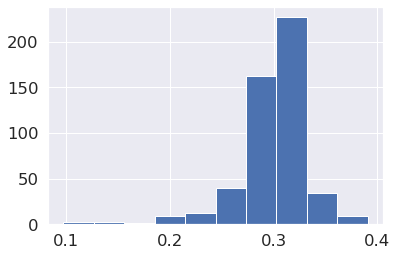

In [23]:
plt.hist(fset_cesium.iloc[:, 1])

In [24]:
fset_cesium['classes'] = eeg['classes']

In [25]:
fset_cesium.columns = fset_cesium.columns.droplevel(-1)

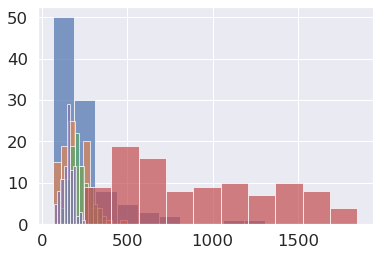

In [26]:
fset_cesium.groupby('classes')['amplitude'].hist(alpha=0.7);

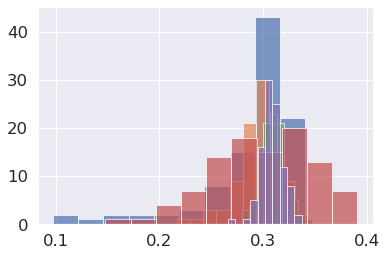

In [27]:
fset_cesium.groupby('classes')['percent_beyond_1_std'].hist(alpha=0.7);

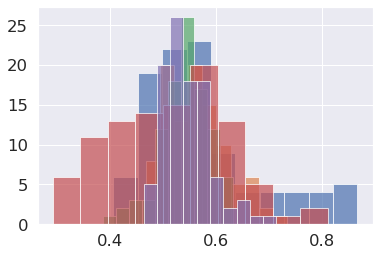

In [28]:
fset_cesium.groupby('classes')['percent_close_to_median'].hist(alpha=0.7);

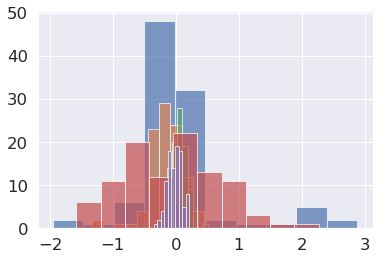

In [29]:
fset_cesium.groupby('classes')['skew'].hist(alpha=0.7);

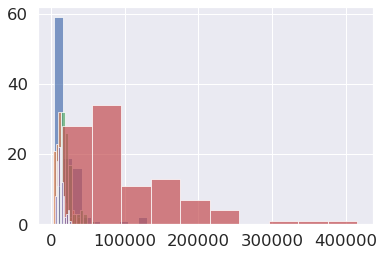

In [30]:
fset_cesium.groupby('classes')['max_slope'].hist(alpha=0.7);

In [31]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
r = pca.fit_transform(fset_cesium.iloc[:, 0:5])

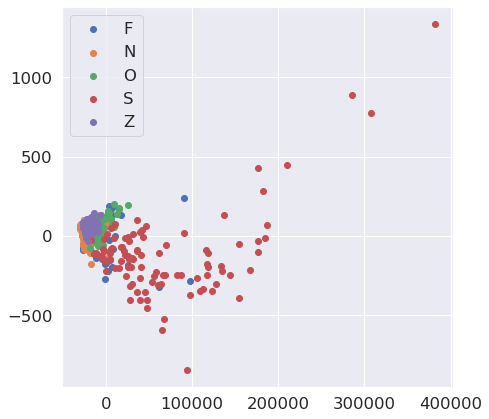

In [32]:
df_pca = pd.DataFrame(r, columns=["f1", "f2"]).assign(classes=eeg['classes'])
grp = df_pca.groupby("classes")

fig = plt.figure(figsize=(7, 7))
ax = fig.subplots(1, 1)
for i, (k, idxs) in enumerate(grp.groups.items()):
    df_tmp = df_pca.loc[idxs]
    ax.scatter(df_tmp.f1, df_tmp.f2, color=c_list[i], label=k);
ax.legend();

(-500.0, 500.0)

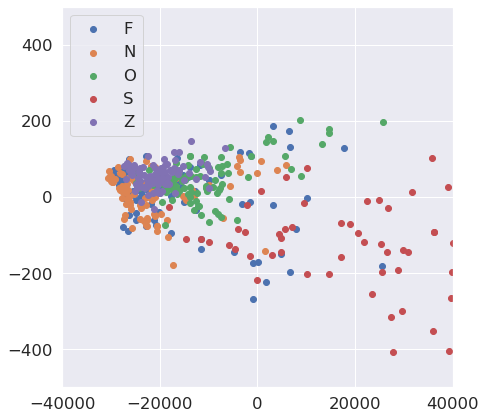

In [33]:
fig = plt.figure(figsize=(7, 7))
ax = fig.subplots(1, 1)
for i, (k, idxs) in enumerate(grp.groups.items()):
    df_tmp = df_pca.loc[idxs]
    ax.scatter(df_tmp.f1, df_tmp.f2, color=c_list[i], label=k);
ax.legend();
ax.set_xlim((-40000, 40000));
ax.set_ylim((-500, 500))

### Tree-based

ここでは、上記時系列データを分類する問題をTreeベースの二つの手法を使って解くことを試みる。

- ランダムフォレスト
  - 多数の決定木を使って多数決により決定する
  - バギング(bagging): 学習データの異なる多数の学習器（決定木）を並列に学習
- XGBoost
  - 学習器を連続的に学習していく
  - 斬差を予測する学習器（決定木）を追加していくという方法

#### データ準備

学習用と評価用にデータを分割する

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    fset_cesium.iloc[:, 0:5].values, eeg["classes"], random_state=21
)

In [36]:
X_test[:5]

array([[ 1.10000000e+02,  3.21454723e-01,  5.32584818e-01,
         5.16415842e-02,  8.67796610e+03],
       [ 3.35500000e+02,  2.35050037e-01,  5.18428118e-01,
         1.10743966e+00,  3.40176271e+04],
       [ 2.24000000e+02,  2.75323407e-01,  6.39980474e-01,
        -3.48184100e-01,  2.98522034e+04],
       [ 1.87500000e+02,  3.01928240e-01,  5.37710520e-01,
        -1.99548260e-01,  1.23227119e+04],
       [ 4.27000000e+02,  2.63363437e-01,  5.84574079e-01,
        -5.89169438e-01,  4.28691525e+04]])

In [37]:
y_test[:5]

array(['O', 'S', 'N', 'F', 'S'], dtype='<U1')

#### ランダムフォレスト

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
%%time
rf_clf = RandomForestClassifier(
    n_estimators=10, max_depth=3, random_state=21
)
rf_clf.fit(X_train, y_train)

CPU times: user 87.8 ms, sys: 4.12 ms, total: 91.9 ms
Wall time: 87.8 ms


RandomForestClassifier(max_depth=3, n_estimators=10, random_state=21)

In [40]:
print(rf_clf.score(X_test, y_test))

0.616


#### XGBoost

In [41]:
# !pip install xgboost

In [42]:
import xgboost as xgb

In [43]:
%%time
xgb_clf = xgb.XGBClassifier(
    n_estimators=10, max_depth=3, random_state=21
)
xgb_clf.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:37:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 2.61 s, sys: 27.7 ms, total: 2.64 s
Wall time: 466 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=7,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=21, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [44]:
print(xgb_clf.score(X_test, y_test))

0.688


#### パラメータを変更してスコアの確認

In [45]:
# random forest
rf_clf = RandomForestClassifier(
    n_estimators=10, max_depth=2, random_state=21
)
rf_clf.fit(X_train, y_train)
print(rf_clf.score(X_test, y_test))

0.544


In [46]:
# XGBoost
xgb_clf = xgb.XGBClassifier(
    n_estimators=10, max_depth=2, random_state=21
)
xgb_clf.fit(X_train, y_train)
print(xgb_clf.score(X_test, y_test))

[06:37:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.696


## 9.2 クラスタリング

### ここで扱うデータ

FiftyWords dataset

- 元論文
  - http://ciir.cs.umass.edu/pubfiles/mm-38.pdf
- 目的
  - 文書インデックス付のために、手書き文字の分類をする
- データ
  - 手書き単語の画像から、高さを計測したものを並べたもの。
  - ５０単語ある（50class）
  - 270ポイント計測
- データの取得もと
  - http://www.timeseriesclassification.com/description.php?Dataset=FiftyWords
    - ここに記載の情報だけでわかるもんなの？せめて論文へのリンクを貼るくらいしたら良くない？？
- データファイル(`*.txt`)
  - 1列目にクラスラベル
  - 2列目以降にデータ

書籍で紹介されているデータは、上記のtestデータのようだが、ちょっと違うっぽい。
まぁ瑣末なことなので、ここで扱うデータに沿って進めていく。  
（サポートリポジトリでもエラーがでてるコードをそのまま掲載しているあたり、うんこうんことしか言いようがないな。）

In [47]:
words = np.loadtxt("data/FiftyWords/FiftyWords_TEST.txt")
print(words.shape)
words_train = np.loadtxt("data/FiftyWords/FiftyWords_TRAIN.txt")
print(words_train.shape)

(455, 271)
(450, 271)


In [48]:
words_train = pd.DataFrame(words_train)
words_train.rename(columns={0:'word'}, inplace=True)
words_train.groupby("word").count()[1]

word
1.0     52
2.0     49
3.0     33
4.0     20
5.0     13
6.0     15
7.0     16
8.0     11
9.0     11
10.0    10
11.0    10
12.0    13
13.0    14
14.0     8
15.0     7
16.0     6
17.0     7
18.0     8
19.0     9
20.0     7
21.0     7
22.0     5
23.0     6
24.0     4
25.0     2
26.0     6
27.0     4
28.0     6
29.0     4
30.0     6
31.0     3
32.0     7
33.0     5
34.0     3
35.0     6
36.0     6
37.0     5
38.0     4
39.0     4
40.0     4
41.0     1
42.0     2
43.0     4
44.0     6
45.0     4
46.0     4
47.0     4
48.0     5
49.0     2
50.0     2
Name: 1, dtype: int64

In [49]:
words_train.head()

,word,1,2,3,4,5,6,7,8,9,...,261,262,263,264,265,266,267,268,269,270
0,9.0,-0.790419,-0.765171,-0.733542,-0.699633,-0.667740,-0.638633,-0.611808,-0.587282,-0.564301,...,-0.592322,-0.621745,-0.654709,-0.690325,-0.727638,-0.764249,-0.794860,-0.814730,-0.822708,-0.821335
1,18.0,-0.764061,-0.744448,-0.743794,-0.720950,-0.717986,-0.702817,-0.691825,-0.680799,-0.671426,...,-0.528000,-0.453934,-0.365317,-0.311797,-0.336820,-0.429081,-0.534639,-0.629839,-0.711351,-0.774474
2,1.0,-0.817041,-0.733105,-0.627820,-0.495715,-0.334888,-0.143279,0.077817,0.322732,0.586229,...,-0.905360,-0.909609,-0.914889,-0.921817,-0.931149,-0.942135,-0.952195,-0.959054,-0.961743,-0.960863
3,5.0,-1.103800,-1.071184,-1.024899,-0.967286,-0.905158,-0.844317,-0.783511,-0.720846,-0.658545,...,-0.953409,-0.974656,-1.000649,-1.031489,-1.064847,-1.095615,-1.119025,-1.132397,-1.135890,-1.132663
4,4.0,-0.435999,-0.316359,-0.211705,-0.114854,-0.019499,0.070713,0.143294,0.193429,0.226835,...,-0.049013,-0.163001,-0.264176,-0.348394,-0.408835,-0.446383,-0.475579,-0.516469,-0.579940,-0.650409


In [50]:
words = pd.DataFrame(words)
words.rename(columns={0:'word'}, inplace=True)
words.groupby("word").count()[1]

word
1.0     57
2.0     42
3.0     28
4.0     34
5.0     25
6.0     19
7.0     16
8.0     13
9.0     13
10.0    12
11.0    12
12.0     9
13.0     7
14.0    10
15.0     9
16.0     8
17.0     7
18.0     5
19.0     4
20.0     6
21.0     5
22.0     6
23.0     4
24.0     6
25.0     8
26.0     4
27.0     6
28.0     3
29.0     5
30.0     3
31.0     6
32.0     2
33.0     3
34.0     5
35.0     2
36.0     2
37.0     3
38.0     4
39.0     4
40.0     4
41.0     6
42.0     5
43.0     3
44.0     1
45.0     3
46.0     3
47.0     3
48.0     2
49.0     4
50.0     4
Name: 1, dtype: int64

In [51]:
words.head(n=10)

,word,1,2,3,4,5,6,7,8,9,...,261,262,263,264,265,266,267,268,269,270
0,4.0,-0.890942,-0.860995,-0.824383,-0.782136,-0.735733,-0.686906,-0.637538,-0.589371,-0.543422,...,-0.863088,-0.867915,-0.872706,-0.878459,-0.885916,-0.896189,-0.907832,-0.919418,-0.930178,-0.939390
1,12.0,-0.783462,-0.685617,-0.584090,-0.479456,-0.373979,-0.270075,-0.172249,-0.087463,-0.019191,...,-0.883177,-0.891895,-0.902895,-0.914267,-0.926679,-0.939662,-0.952445,-0.966233,-0.980498,-0.991776
2,13.0,-1.325568,-1.284301,-1.219683,-1.156749,-1.099784,-1.049563,-1.015452,-0.996718,-0.985036,...,-0.834992,-0.862044,-0.885588,-0.904536,-0.933529,-0.991349,-1.069073,-1.136840,-1.197966,-1.269968
3,23.0,-1.093671,-1.041959,-0.998400,-0.959970,-0.939970,-0.937637,-0.926489,-0.857090,-0.693318,...,-0.728100,-0.745120,-0.763757,-0.780677,-0.805933,-0.843500,-0.895309,-0.960517,-1.050865,-1.128298
4,4.0,-0.901379,-0.852280,-0.801957,-0.749324,-0.692982,-0.633165,-0.570379,-0.506921,-0.446042,...,-0.954519,-0.973216,-0.989844,-1.005241,-1.018838,-1.029610,-1.036981,-1.041109,-1.041832,-1.040316
5,13.0,-1.244651,-1.219989,-1.169424,-1.091314,-0.989682,-0.868285,-0.734625,-0.595374,-0.457100,...,-0.598989,-0.690780,-0.784095,-0.873218,-0.951004,-1.015454,-1.070477,-1.121955,-1.172831,-1.216697
6,27.0,-1.075072,-0.554935,0.060346,0.450901,0.732460,0.905227,0.830938,0.610323,0.380247,...,-0.818506,-0.806425,-0.790015,-0.763001,-0.747978,-0.791418,-0.856929,-0.922587,-1.026237,-1.141711
7,1.0,-0.836163,-0.818055,-0.792500,-0.764711,-0.739226,-0.717098,-0.698077,-0.680866,-0.666010,...,-0.722790,-0.723530,-0.728935,-0.739159,-0.756097,-0.781150,-0.811002,-0.836686,-0.850178,-0.850922
8,22.0,-1.277491,-1.191953,-1.055896,-0.879977,-0.668991,-0.427050,-0.167035,0.087073,0.310424,...,-0.927093,-0.954587,-0.991839,-1.036875,-1.089425,-1.151742,-1.221964,-1.285693,-1.322701,-1.328951
9,1.0,-0.612393,-0.564663,-0.592527,-0.656354,-0.682127,-0.662843,-0.650048,-0.658515,-0.655265,...,-0.242272,-0.284368,-0.331438,-0.379252,-0.430904,-0.488278,-0.539126,-0.580239,-0.627233,-0.688011


### データの確認

wordカテゴリの標本をいくつかplotしてみる。
また、値の単純な1次元ヒストグラムを確認する。

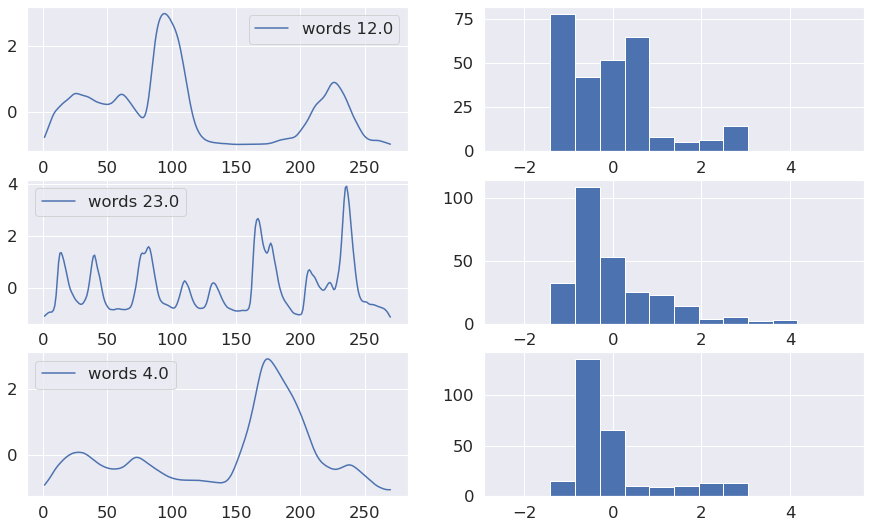

In [52]:
select_idxs = [1, 3, 4]
n = len(select_idxs)

max_val = words.loc[:, 1:].max().max()
min_val = words.loc[:, 1:].min().min()
bins = np.linspace(min_val, max_val, 15)

fig = plt.figure(figsize=(15, 3*n))
ax = fig.subplots(n, 2)

for i, idx in enumerate(select_idxs):
    ax[i, 0].plot(words.loc[idx, 1:], label=f"words {words.word[idx]}");
    ax[i, 0].legend();
    ax[i, 1].hist(words.loc[idx, 1:], bins=bins);

`hist`でbinsオプションに10を指定するだけだとビンの幅や位置が異なるので、上記ではビンを揃えている。

たぶん、`subplots`でsharexをTrueにすれば、書籍のような図は書けると思う。（あまり意味はないけど）

つづいて、wordカテゴリ毎の傾向を確認するために、2次元ヒストグラムを確認する。

Text(0, 0.5, 'Value')

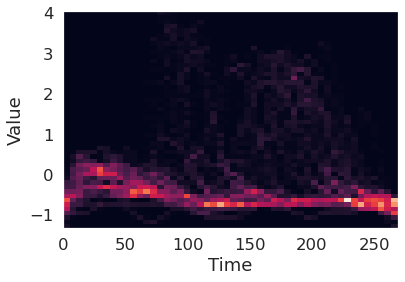

In [53]:
x = np.array([])
y = np.array([])

w = 4
selected_words = words[words.word == w]
selected_words.shape

for idx, row in selected_words.iterrows():
    y = np.hstack([y, row[1:271]])
    x = np.hstack([x, np.array(range(270))])
    
fig, ax = plt.subplots()
hist = ax.hist2d(x, y, bins = 50)
plt.xlabel("Time", fontsize = 18)
plt.ylabel("Value", fontsize = 18)

これ、わかりにくいと思うんだよね。なので、alphaチャンネルを小さくして系列を重ねて描いてみる。

(34, 270)


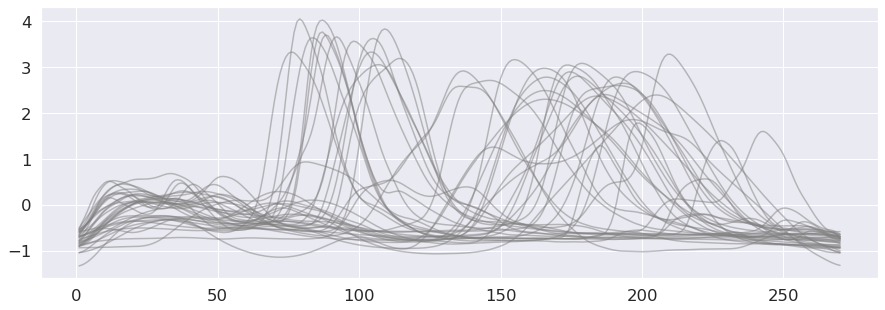

In [54]:
w1 = words[words.word == w].loc[:, 1:]
print(w1.shape)

fig = plt.figure(figsize=(15, 5))
ax = fig.subplots(1, 1)

for i in range(w1.shape[0]):
    ax.plot(w1.iloc[i,:], color="gray", alpha=0.5)

だいぶバリエーション豊富ですね。

### 特徴量生成

上記のデータ確認結果から、ピークはあるがその位置は安定しないという状況を考慮して特徴量を作成する。

cesiumパッケージを使って実装済みの特徴量を計算する(「分類」の項目での特徴量生成と同じ)。

In [55]:
from cesium import featurize

words_features = words.iloc[:, 1:]
times  = []
values = []
for idx, row in words_features.iterrows():
    values.append(row.values)
    times.append(np.array([i for i in range(row.values.shape[0])]))

features_to_use = [
    "amplitude",
    "percent_beyond_1_std",
    "percent_close_to_median",
]
featurized_words = featurize.featurize_time_series(
    times=times,
    values=values,
    errors=None,
    features_to_use=features_to_use,
    scheduler = None, 
)

In [56]:
display(len(values))
display(values[0].shape)

455

(270,)

In [57]:
display(len(times))
display(times[0].shape)

455

(270,)

In [58]:
display(type(featurized_words))

pandas.core.frame.DataFrame

In [59]:
featurized_words.shape

(455, 3)

In [60]:
featurized_words.head()

feature,amplitude,percent_beyond_1_std,percent_close_to_median
channel,0,0,0
0,1.674549,0.188889,0.451852
1,1.990515,0.118519,0.259259
2,2.903646,0.114815,0.637037
3,2.515061,0.211111,0.562963
4,1.966152,0.181481,0.533333


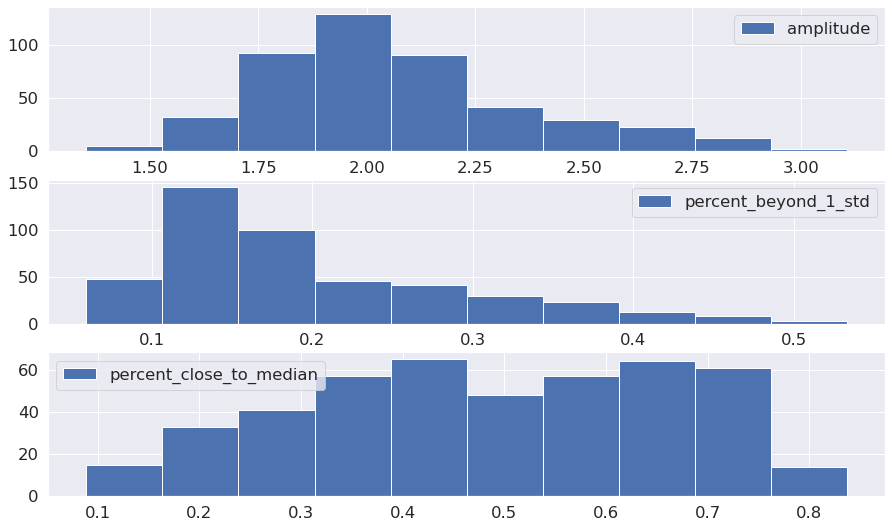

In [61]:
n = len(features_to_use)

fig = plt.figure(figsize=(15, 3*n))
ax = fig.subplots(n, 1)
for i, f in enumerate(features_to_use):
    ax[i].hist(featurized_words[f], label=f);
    ax[i].legend();

さらに1次元のヒストグラムを使って特徴量を生成する。

rangeの指定はこれで良いのだろうか？外れ値を除外する的な使い方ができるのかな。。。

In [62]:
times = []
hist_values = []
for idx, row in words_features.iterrows():
    hist_values.append(
        np.histogram(row.values, bins=10, range=(-2.5, 5.0))[0] + .0001 # 0にならないように小さい値を足している(cesiumの問題)
    )
    times.append(np.array([i for i in range(9)]))

features_to_use = [
    "amplitude",
    "percent_close_to_median",
    "skew"
]
featurized_hists = featurize.featurize_time_series(
    times=times,
    values=hist_values,
    errors=None,
    features_to_use=features_to_use,
    scheduler = None
)

In [63]:
display(len(hist_values))
display(hist_values[0].shape)

455

(10,)

In [64]:
featurized_hists.shape

(455, 3)

In [65]:
featurized_hists.head()

feature,amplitude,percent_close_to_median,skew
channel,0,0,0
0,88.0,0.444444,2.262655
1,61.0,0.666667,1.285343
2,70.0,0.666667,1.683031
3,67.0,0.555556,1.724109
4,75.0,0.777778,1.902513


これらの特徴量を結合する

In [66]:
features = pd.concat([featurized_words.reset_index(drop=True), featurized_hists], axis=1)

display(features.shape)
display(features.head())

(455, 6)

feature,amplitude,percent_beyond_1_std,percent_close_to_median,amplitude,percent_close_to_median,skew
channel,0,0,0,0,0,0
0,1.674549,0.188889,0.451852,88.0,0.444444,2.262655
1,1.990515,0.118519,0.259259,61.0,0.666667,1.285343
2,2.903646,0.114815,0.637037,70.0,0.666667,1.683031
3,2.515061,0.211111,0.562963,67.0,0.555556,1.724109
4,1.966152,0.181481,0.533333,75.0,0.777778,1.902513


この特徴量もPCAして二次元にマッピングしてみよう

In [67]:
pca = PCA(n_components=2)
r = pca.fit_transform(features.values)

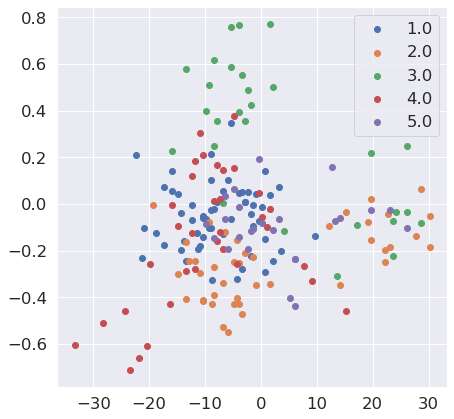

In [68]:
df_pca = pd.DataFrame(r, columns=["f1", "f2"]).assign(classes=words.word)
df_pca_reduce = df_pca[df_pca.classes < 6]
grp = df_pca_reduce.groupby("classes")

fig = plt.figure(figsize=(7, 7))
ax = fig.subplots(1, 1)
for i, (k, idxs) in enumerate(grp.groups.items()):
    df_tmp = df_pca_reduce.loc[idxs]
    ax.scatter(df_tmp.f1, df_tmp.f2, color=c_list[i], label=k);
ax.legend();

厳しそうな気配がするけどな。

### 時間を意識する距離

時系列データをそのまま比較するための計量手法。時系列（曲線）の形状を比較するという考え。

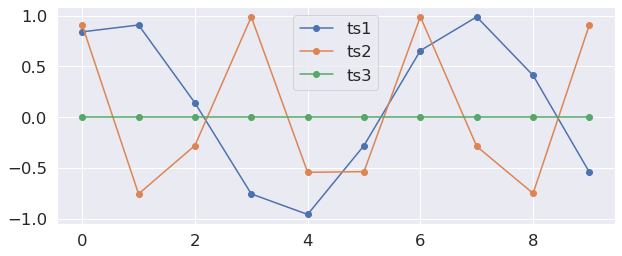

In [117]:
n = 10
ts1 = np.sin(np.linspace(1, 10, n))
ts2 = np.sin(2 * np.linspace(1, 10, n))
ts3 = np.zeros((n,)) 

fig = plt.figure(figsize=(10, 4))
ax = fig.subplots(1, 1)
ax.plot(ts1, "-o", label="ts1");
ax.plot(ts2, "-o", label="ts2");
ax.plot(ts3, "-o", label="ts3");
ax.legend();

In [118]:
def distDTW(ts1, ts2):
    DTW = {}
    for i in range(len(ts1)):
        DTW[(i, -1)] = np.inf
    for i in range(len(ts2)): 
        DTW[(-1, i)] = np.inf
    DTW[(-1, -1)] = 0
    
    for i in range(len(ts1)):
        for j in range(len(ts2)):
            dist = (ts1[i] - ts2[j]) ** 2
            DTW[(i, j)] = dist + min(DTW[i-1, j], DTW[i, j-1], DTW[i-1, j-1])
    return np.sqrt(DTW[len(ts1)-1, len(ts2)-1]), DTW

distance(DTW): 2.1605346534830256


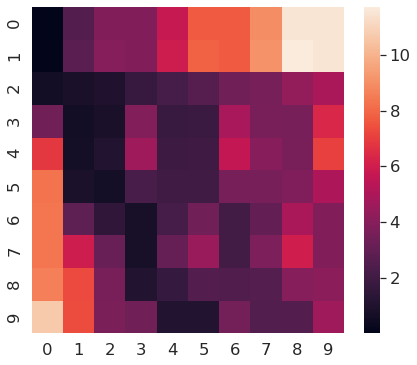

In [119]:
d, DTW = distDTW(ts1, ts2)
print(f"distance(DTW): {d}")

Z = np.zeros((len(ts1), len(ts2)), dtype=float)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i, j] = DTW[(i, j)]

fig = plt.figure(figsize=(7, 6))
ax = fig.subplots(1, 1)
sns.heatmap(Z, ax=ax);

distance(DTW): 2.2363878539925763


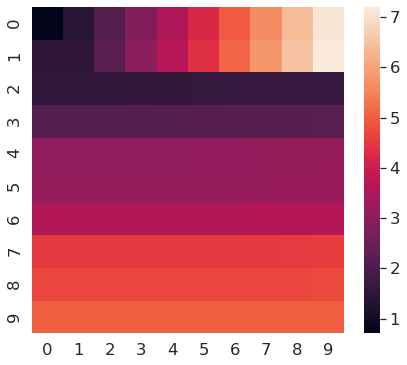

In [120]:
d, DTW = distDTW(ts1, ts3)
print(f"distance(DTW): {d}")

Z = np.zeros((len(ts1), len(ts3)), dtype=float)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i, j] = DTW[(i, j)]

fig = plt.figure(figsize=(7, 6))
ax = fig.subplots(1, 1)
sns.heatmap(Z, ax=ax);

このヒートマップで示される「距離」を最小にするような経路が最適経路。

最適経路を計算するためのアルゴリズムが「ビタビアルゴリズム」という理解で合ってる？

### 正規化した特徴量での階層的クラスタリング

- 特徴量を正規化
- sklearnの階層的クラスタリングを実行
  - ユークリッド距離（default）
  - ward法（クラスタ距離はクラスタ内の差の2乗を使い、差の2乗の合計を最小化する）


In [121]:
features.head()

feature,amplitude,percent_beyond_1_std,percent_close_to_median,amplitude,percent_close_to_median,skew
channel,0,0,0,0,0,0
0,1.674549,0.188889,0.451852,88.0,0.444444,2.262655
1,1.990515,0.118519,0.259259,61.0,0.666667,1.285343
2,2.903646,0.114815,0.637037,70.0,0.666667,1.683031
3,2.515061,0.211111,0.562963,67.0,0.555556,1.724109
4,1.966152,0.181481,0.533333,75.0,0.777778,1.902513


まずは正規化。平均0で分散1になるように。

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html

In [122]:
from sklearn import preprocessing
feature_values = preprocessing.scale(features.values)

sklearnのAgglomerativeClusteringを使う。

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

In [125]:
from sklearn.cluster import AgglomerativeClustering
feature_clustering = AgglomerativeClustering(
    linkage='ward', n_clusters=50, affinity='euclidean')
feature_clustering.fit(feature_values)
words["feature_labels"] = feature_clustering.fit_predict(feature_values)

In [126]:
from sklearn.metrics.cluster import homogeneity_score
homogeneity_score(words.word, words.feature_labels)

0.5085776345414814

クラスタIDは一致するわけではないので、推定値とラベルのクラスタの均一性を評価する。
つまり、正解が同じクラスタの中に、同じIDが推定されているかどうかを評価する。

In [137]:
words[["word", "feature_labels"]].head(n=10)

,word,feature_labels
0,4.0,14
1,12.0,23
2,13.0,47
3,23.0,41
4,4.0,11
5,13.0,1
6,27.0,1
7,1.0,38
8,22.0,39
9,1.0,16


### DTW距離行列を使ったクラスタリング

In [150]:
def distDTW(ts1, ts2):
    DTW = {}
    for i in range(len(ts1)):
        DTW[(i, -1)] = np.inf
    for i in range(len(ts2)): 
        DTW[(-1, i)] = np.inf
    DTW[(-1, -1)] = 0
    
    for i in range(len(ts1)):
        for j in range(len(ts2)):
            dist = (ts1[i] - ts2[j]) ** 2
            DTW[(i, j)] = dist + min(DTW[i-1, j], DTW[i, j-1], DTW[i-1, j-1])
    return np.sqrt(DTW[len(ts1)-1, len(ts2)-1])

In [145]:
from sklearn.metrics.pairwise import pairwise_distances

In [143]:
X = words.iloc[:, 1:271].values

Xのそれぞれの要素（ベクトル）の距離を計算する。

戻り値は、 (n_samples_X, n_samples_X)のndarray。

メモリ？動作が止まってしまったので完遂せず。


In [ ]:
# %%time
# p = pairwise_distances(X, metric = distDTW)

In [ ]:
# with open("pairwise_word_distances.npy", "wb") as f:
#     np.save(f, p)

In [ ]:
# dtw_clustering = AgglomerativeClustering(
#     linkage='average', n_clusters=50, affinity='precomputed')
# #dtw_clustering.fit(p)%
# words["dtw_labels"] = dtw_clustering.fit_predict(p)

In [ ]:
# homogeneity_score(words.word, words.dtw_labels)